# Example of DOV search methods for boreholes (boringen)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/DOV-Vlaanderen/pydov/master?filepath=docs%2Fnotebooks%2Fsearch_boringen.ipynb)

## Use cases explained below
* Get boreholes in a bounding box
* Get boreholes with specific properties
* Get boreholes in a bounding box based on specific properties
* Select boreholes in a municipality and return depth
* Get boreholes based on fields not available in the standard output dataframe
* Get borehole data, returning fields not available in the standard output dataframe
* Get boreholes in a municipality and where groundwater related data are available
* Adding location and height details
* Adding color to the Borehole dataframe

In [1]:
%matplotlib inline
import inspect, sys
import warnings; warnings.simplefilter('ignore')

In [2]:
# check pydov path
import pydov

## Get information about the datatype 'Boring'

In [3]:
from pydov.search.boring import BoringSearch
boring = BoringSearch()

A description is provided for the 'Boring' datatype:

In [4]:
boring.get_description()

'In de DOV-databank is elke waarneming van grondlagen een boring. Bij de meeste boringen wordt er met een boortoestel een gat gemaakt in de ondergrond om de verschillende grondlagen te kunnen beschrijven. Aan de hand van een boring krijg je een beeld van het materiaal in de ondergrond met toenemende diepte. Afhankelijk van het doel waarvoor de boring geplaatst wordt, zal men een geschikte boormethode toepassen. Boringen worden geplaatst voor verkennend bodemonderzoek, monstername van het sediment en/of grondwater, bepaling van bodemfysische parameters, milieuhygiënisch onderzoek,… Afhankelijk van de diepte, soort materiaal, en het al dan niet boren tot onder de grondwatertafel kan men kiezen uit verscheidene systemen voor handmatig of machinaal te boren. Het bodemmateriaal dat vrijkomt, kan gebruikt worden om een profiel van de ondergrond op te stellen of om er grondmonsters van te nemen om verdere analyses op uit te voeren. Vaak is het de bedoeling een put uit te bouwen zodat water ka

The different fields that are available for objects of the 'Boring' datatype can be requested with the get_fields() method:

In [5]:
fields = boring.get_fields()

# print available fields
for f in fields.values():
    print(f['name'])

id
boornummer
pkey_boring
rapport
diepte_boring_tot
datum_aanvang
namen
putnummer
x
y
start_boring_mtaw
gemeente
uitvoerder
doel
methode
erkenning
opdrachtgever
informele_stratigrafie
formele_stratigrafie
lithologische_beschrijving
gecodeerde_lithologie
hydrogeologische_stratigrafie
quartaire_stratigrafie
geotechnische_codering
informele_hydrostratigrafie
doorheen_quartair
dikte_quartair
tertiair_onder_quartair
opdrachten
eerste_invoer
geom
diepte_boring_van
boorgatmeting
diepte_methode_van
diepte_methode_tot
boormethode
mv_mtaw


You can get more information of a field by requesting it from the fields dictionary:

* *name*: name of the field
* *definition*: definition of this field
* *cost*: currently this is either 1 or 10, depending on the datasource of the field. It is an indication of the expected time it will take to retrieve this field in the output dataframe.
* *notnull*: whether the field is mandatory or not
* *type*: datatype of the values of this field
* *codelist*: optionally, a codelist that describes the possible values of this field

Alternatively, you can list all the fields and their details by inspecting the `get_fields()` output or the search instance itself in a notebook:

In [6]:
boring

## Example use cases

### Get boreholes in a bounding box

Get data for all the boreholes that are geographically located within the bounds of the specified box.

The coordinates are in the Belgian Lambert72 (EPSG:31370) coordinate system and are given in the order of lower left x, lower left y, upper right x, upper right y.

In [7]:
from pydov.util.location import Within, Box

df = boring.search(location=Within(Box(153145, 206930, 153150, 206935)))
df.head()

[000/001] .
[000/001] .


,pkey_boring,boornummer,x,y,mv_mtaw,start_boring_mtaw,gemeente,diepte_boring_van,diepte_boring_tot,datum_aanvang,uitvoerder,boorgatmeting,diepte_methode_van,diepte_methode_tot,boormethode
0,https://www.dov.vlaanderen.be/data/boring/1974...,GEO-74/254-b1,153147.0,206931.0,NaN,14.12,NaN,0.0,14.05,1974-07-02,Rijksinstituut voor Grondmechanica,False,0.0,1.30,lepelboring
1,https://www.dov.vlaanderen.be/data/boring/1974...,GEO-74/254-b1,153147.0,206931.0,NaN,14.12,NaN,0.0,14.05,1974-07-02,Rijksinstituut voor Grondmechanica,False,1.3,13.50,pulsboring
2,https://www.dov.vlaanderen.be/data/boring/1974...,GEO-74/254-b1,153147.0,206931.0,NaN,14.12,NaN,0.0,14.05,1974-07-02,Rijksinstituut voor Grondmechanica,False,13.5,14.05,lepelboring


The dataframe contains one borehole where three methods ('boormethode') were applied for its construction. The available data are flattened to represent unique attributes per row of the dataframe.

Using the *pkey_boring* field one can request the details of this borehole in a webbrowser:

In [8]:
for pkey_boring in set(df.pkey_boring):
    print(pkey_boring)

https://www.dov.vlaanderen.be/data/boring/1974-010351


### Get boreholes with specific properties

Next to querying boreholes based on their geographic location within a bounding box, we can also search for boreholes matching a specific set of properties. For this we can build a query using a combination of the 'Boring' fields and operators provided by the WFS protocol.

A list of possible operators can be found below:

In [9]:
[i for i,j in inspect.getmembers(sys.modules['owslib.fes2'], inspect.isclass) if 'Property' in i]

['PropertyIsBetween',
 'PropertyIsEqualTo',
 'PropertyIsGreaterThan',
 'PropertyIsGreaterThanOrEqualTo',
 'PropertyIsLessThan',
 'PropertyIsLessThanOrEqualTo',
 'PropertyIsLike',
 'PropertyIsNotEqualTo',
 'PropertyIsNull',
 'SortProperty']

In this example we build a query using the *PropertyIsEqualTo* operator to find all boreholes that are within the community (gemeente) of 'Herstappe':

In [10]:
from owslib.fes2 import PropertyIsEqualTo

query = PropertyIsEqualTo(propertyname='gemeente',
                          literal='Herstappe')
df = boring.search(query=query)

df.head()

[000/001] .
[000/002] ..


,pkey_boring,boornummer,x,y,mv_mtaw,start_boring_mtaw,gemeente,diepte_boring_van,diepte_boring_tot,datum_aanvang,uitvoerder,boorgatmeting,diepte_methode_van,diepte_methode_tot,boormethode
0,https://www.dov.vlaanderen.be/data/boring/2016...,kb33d106e-B236,224687.4,158191.0,124.0,124.0,Herstappe,0.0,6.0,NaN,Belgische Geologische Dienst (BGD),False,0.0,6.0,gestoken boring
1,https://www.dov.vlaanderen.be/data/boring/1993...,kb41d120e-B1027,224820.0,157794.0,132.0,132.0,Herstappe,0.0,50.0,1993-09-02,Peeters-Ramsel,False,0.0,50.0,onbekend


Once again we can use the *pkey_boring* as a permanent link to the information of these boreholes:

In [11]:
for pkey_boring in set(df.pkey_boring):
    print(pkey_boring)

https://www.dov.vlaanderen.be/data/boring/2016-125511
https://www.dov.vlaanderen.be/data/boring/1993-096210


### Get boreholes in a bounding box based on specific properties

We can combine a query on attributes with a query on geographic location to get the boreholes within a bounding box that have specific properties.

The following example requests the boreholes with a depth greater than or equal to 2000 meters within the given bounding box.

(Note that the datatype of the *literal* parameter should be a string, regardless of the datatype of this field in the output dataframe.)

In [12]:
from owslib.fes2 import PropertyIsGreaterThanOrEqualTo

query = PropertyIsGreaterThanOrEqualTo(
            propertyname='diepte_boring_tot',
            literal='2000')

df = boring.search(
    location=Within(Box(200000, 211000, 205000, 214000)),
    query=query
    )

df.head()

[000/001] .
[000/006] ......


,pkey_boring,boornummer,x,y,mv_mtaw,start_boring_mtaw,gemeente,diepte_boring_van,diepte_boring_tot,datum_aanvang,uitvoerder,boorgatmeting,diepte_methode_van,diepte_methode_tot,boormethode
0,https://www.dov.vlaanderen.be/data/boring/2016...,B/1-102782,201775.5,212960.0,25.0,25.0,Mol,0.0,3600.0,NaN,NaN,False,0.0,0.0,onbekend
1,https://www.dov.vlaanderen.be/data/boring/2016...,B/1-102783,201798.0,212963.0,25.0,25.0,Mol,0.0,3600.0,NaN,NaN,False,0.0,0.0,onbekend
2,https://www.dov.vlaanderen.be/data/boring/2016...,B/1-102784,201768.0,212959.0,25.0,25.0,Mol,0.0,4905.0,2017-12-13,THV Daldrup - Smet,True,0.0,207.0,zuigboring
3,https://www.dov.vlaanderen.be/data/boring/2016...,B/1-102784,201768.0,212959.0,25.0,25.0,Mol,0.0,4905.0,2017-12-13,THV Daldrup - Smet,True,207.0,4905.0,spoelboring
4,https://www.dov.vlaanderen.be/data/boring/2016...,B/1-102785,201790.5,212962.0,25.0,25.0,Mol,0.0,4341.0,2016-03-02,THV Daldrup - Smet,True,0.0,4341.0,spoelboring


We can look at one of the boreholes in a webbrowser using its *pkey_boring*:

In [13]:
for pkey_boring in set(df.pkey_boring):
    print(pkey_boring)

https://www.dov.vlaanderen.be/data/boring/2016-148767
https://www.dov.vlaanderen.be/data/boring/2016-148763
https://www.dov.vlaanderen.be/data/boring/2016-148766
https://www.dov.vlaanderen.be/data/boring/2016-148770
https://www.dov.vlaanderen.be/data/boring/2016-148765
https://www.dov.vlaanderen.be/data/boring/2016-148764


### Select boreholes in a municipality and return depth

We can limit the columns in the output dataframe by specifying the *return_fields* parameter in our search.

In this example we query all the boreholes in the city of Ghent and return their depth:

In [14]:
query = PropertyIsEqualTo(propertyname='gemeente',
                          literal='Gent')
df = boring.search(query=query,
                   return_fields=('diepte_boring_tot',))
df.head()

[000/001] .


,diepte_boring_tot
0,42.0
1,32.0
2,59.0
3,11.0
4,27.0


In [15]:
df.describe()

,diepte_boring_tot
count,3328.000000
mean,20.565406
std,38.105328
min,0.000000
25%,2.200000
50%,7.000000
75%,20.000000
max,660.000000


By discarding the boreholes with a depth of 0 m, we get a different result:

In [16]:
df[df.diepte_boring_tot != 0].describe()

,diepte_boring_tot
count,2671.000000
mean,25.623987
std,40.983414
min,0.100000
25%,5.000000
50%,10.000000
75%,24.000000
max,660.000000


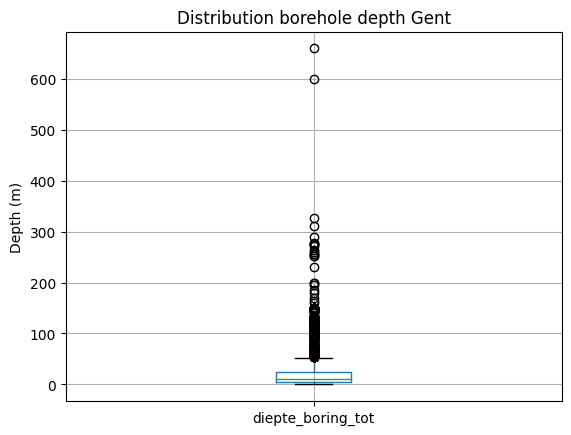

In [17]:
ax = df[df.diepte_boring_tot != 0].boxplot()
ax.set_ylabel("Depth (m)");
ax.set_title("Distribution borehole depth Gent");

### Get boreholes based on fields not available in the standard output dataframe

To keep the output dataframe size acceptable, not all available WFS fields are included in the standard output. However, one can use this information to select boreholes as illustrated below.

For example, make a selection of the boreholes in municipality the of Antwerp, for which a hydrogeological interpretation was performed:

In [18]:
from owslib.fes2 import And

query = And([PropertyIsEqualTo(propertyname='gemeente',
                               literal='Antwerpen'),
             PropertyIsEqualTo(propertyname='hydrogeologische_stratigrafie', 
                               literal='True')]
            )
df = boring.search(query=query,
                   return_fields=('pkey_boring', 'boornummer', 'x', 'y', 'diepte_boring_tot', 'datum_aanvang'))
df.head()

[000/001] .


,pkey_boring,boornummer,x,y,diepte_boring_tot,datum_aanvang
0,https://www.dov.vlaanderen.be/data/boring/1937...,kb7d14e-B82,145457.0,224973.5,10.0,1937-01-01
1,https://www.dov.vlaanderen.be/data/boring/1969...,kb7d14e-B110,143700.4,228086.3,12.0,1969-01-01
2,https://www.dov.vlaanderen.be/data/boring/1966...,kb7d14e-B115,143067.0,227707.6,66.0,1966-01-01
3,https://www.dov.vlaanderen.be/data/boring/1966...,kb7d14e-B117,144770.5,223430.6,49.0,1966-01-01
4,https://www.dov.vlaanderen.be/data/boring/1970...,kb7d14e-B121,143597.8,223498.6,11.9,1970-01-01


### Get borehole data, returning fields not available in the standard output dataframe

As denoted in the previous example, not all available fields are available in the default output frame to keep its size limited. However, you can request any available field by including it in the *return_fields* parameter of the search:

In [19]:
query = PropertyIsGreaterThanOrEqualTo(
            propertyname='diepte_boring_tot',
            literal='2000')

df = boring.search(query=query,
                   return_fields=('pkey_boring', 'boornummer', 'diepte_boring_tot',
                                  'informele_stratigrafie', 'formele_stratigrafie', 'lithologische_beschrijving',
                                  'gecodeerde_lithologie', 'hydrogeologische_stratigrafie', 'quartaire_stratigrafie',
                                  'geotechnische_codering', 'informele_hydrostratigrafie'))

df.head()

[000/001] .


,pkey_boring,boornummer,diepte_boring_tot,informele_stratigrafie,formele_stratigrafie,lithologische_beschrijving,gecodeerde_lithologie,hydrogeologische_stratigrafie,quartaire_stratigrafie,geotechnische_codering,informele_hydrostratigrafie
0,https://www.dov.vlaanderen.be/data/boring/1981...,kb8d7e-B224,2517.0,True,True,True,False,False,False,False,False
1,https://www.dov.vlaanderen.be/data/boring/1952...,kb8d17e-B272,2705.0,True,True,True,True,True,False,False,False
2,https://www.dov.vlaanderen.be/data/boring/1935...,kb17d31e-B197,2034.0,True,True,False,True,True,False,False,False
3,https://www.dov.vlaanderen.be/data/boring/2016...,B/1-102782,3600.0,False,False,False,False,False,False,False,False
4,https://www.dov.vlaanderen.be/data/boring/2016...,B/1-102783,3600.0,False,False,False,False,False,False,False,False


### Get boreholes in a municipality and where groundwater related data are available

The following full example return all boreholes where *gemeente* is 'Antwerpen' and either *putnummer* is not empty or *doel* starts with 'Grondwater' or *erkenning* is '2. Andere grondwaterwinningen'.

In [20]:
from owslib.fes2 import PropertyIsLike
from owslib.fes2 import PropertyIsNull
from owslib.fes2 import Or
from owslib.fes2 import Not

query = And([PropertyIsEqualTo(propertyname='gemeente',
                               literal='Antwerpen'),
             Or([Not([PropertyIsNull(propertyname='putnummer')]),
                PropertyIsLike(propertyname='doel',
                               literal='Grondwater%'),
                PropertyIsEqualTo(propertyname='erkenning', 
                                  literal='2. Andere grondwaterwinningen')]
               )]
           )
df = boring.search(query=query)
df.head()

[000/001] .
[000/214] ..................................................
[050/214] ..................................................
[100/214] ..................................................
[150/214] ..................................................
[200/214] ..............


,pkey_boring,boornummer,x,y,mv_mtaw,start_boring_mtaw,gemeente,diepte_boring_van,diepte_boring_tot,datum_aanvang,uitvoerder,boorgatmeting,diepte_methode_van,diepte_methode_tot,boormethode
0,https://www.dov.vlaanderen.be/data/boring/1967...,kb7d14e-B186,144712.5,222672.3,8.55,8.55,Antwerpen,0.0,12.0,1967-01-01,Smet - Dessel,False,0.0,12.0,spoelboring
1,https://www.dov.vlaanderen.be/data/boring/1967...,kb7d14e-B183,144379.9,222861.3,9.04,9.04,Antwerpen,0.0,12.0,1967-01-01,Smet - Dessel,False,0.0,12.0,spoelboring
2,https://www.dov.vlaanderen.be/data/boring/1967...,kb7d14e-B184,144631.1,222928.6,8.60,8.60,Antwerpen,0.0,17.0,1967-01-01,Smet - Dessel,False,0.0,17.0,spoelboring
3,https://www.dov.vlaanderen.be/data/boring/1967...,kb7d14e-B185,144883.9,223009.9,8.20,8.20,Antwerpen,0.0,12.0,1967-01-01,Smet - Dessel,False,0.0,12.0,spoelboring
4,https://www.dov.vlaanderen.be/data/boring/1967...,kb7d14e-B187,144969.5,222737.8,8.25,8.25,Antwerpen,0.0,12.0,1967-01-01,Smet - Dessel,False,0.0,12.0,spoelboring


## Visualize results

Using Folium, we can display the results of our search on a map.

In [21]:
# import the necessary modules (not included in the requirements of pydov!)
import folium
from folium.plugins import MarkerCluster
from pyproj import Transformer

In [22]:
# convert the coordinates to lat/lon for folium
def convert_latlon(x1, y1):
    transformer = Transformer.from_crs("epsg:31370", "epsg:4326", always_xy=True)
    x2,y2 = transformer.transform(x1, y1)
    return x2, y2

df['lon'], df['lat'] = zip(*map(convert_latlon, df['x'], df['y'])) 
# convert to list
loclist = df[['lat', 'lon']].values.tolist()

In [23]:
# initialize the Folium map on the centre of the selected locations, play with the zoom until ok
fmap = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=12)
marker_cluster = MarkerCluster().add_to(fmap)
for loc in range(0, len(loclist)):
    folium.Marker(loclist[loc], popup=df['boornummer'][loc]).add_to(marker_cluster)
fmap


## Adding location and height details

There is more to the location of a borehole than meets the eye! The default dataframe lists already multiple fields regarding the location of the borehole, both planimetric as altimetric:

* `x` and `y` are the planimetric coordinates of the borehole
* `start_boring_mtaw` is the height of the start (aanvangspeil) of the borehole
* `mv_mtaw` is the height of the ground level at the time of the making of the borehole

However, we have more information available regarding the (origin of) these coordinates. Each of them has an associated method (methode) and reliability (betrouwbaarheid).

We also make the distinction between the height of the ground level (maaiveld) and the height of the start of the borehole (aanvangspeil). If the borehole was started at ground level both are the same, but this is not necessarily the case. Furthermore the height of the start of the borehole can be either absolute (measured individually) or relative to the ground level.

If we want to have all this extra information available when retrieving the borehole dataframe output, we can add the extra XML fields when searching for boreholes.

To find which extra fieldsets are availabe, you can use:

In [24]:
from pydov.types.boring import Boring

Boring.get_fieldsets()

{'MethodeXyz': {'name': 'MethodeXyz',
  'class': pydov.types.boring.MethodeXyz,
  'definition': 'Fieldset containing fields for method and reliability of the point\n    location of the borehole. It has the following fields: methode_xy, betrouwbaarheid_xy, methode_z, betrouwbaarheid_z.'}}

To add the extra fields to your output dataframe, you can specify the fieldset to use when instantiating the search class:

In [25]:
from pydov.search.boring import BoringSearch
from pydov.types.boring import MethodeXyz

boring_search = BoringSearch(
    objecttype=Boring.with_extra_fields(MethodeXyz)
)

The extra fields are now available, and should be included in the output of `get_fields()`. E.g. to get more details about the `methode_z` field:

In [26]:
boring_search.get_fields()['methode_z']

{'name': 'methode_z', 'type': 'string', 'list': False, 'definition': 'Methode waarop de z-coordinaat opgemeten werd.', 'notnull': False, 'query': False, 'cost': 10, 'codelist': <pydov.util.codelists.AbstractCodeList: <pydov.util.codelists.CodeListItem: code: DHM_v1 100m*100m, label: DHM_v1 100m*100m, definition: None>, <pydov.util.codelists.CodeListItem: code: DHM_v1 25m*25m, label: DHM_v1 25m*25m, definition: None>, <pydov.util.codelists.CodeListItem: code: DHM_v1 5m*5m, label: DHM_v1 5m*5m, definition: None>, <pydov.util.codelists.CodeListItem: code: DHM_v2, label: DHM_v2, definition: None>, <pydov.util.codelists.CodeListItem: code: GPS, label: GPS, definition: None>, <pydov.util.codelists.CodeListItem: code: GPS - RTK FLEPOS, label: GPS - RTK FLEPOS, definition: None>, <pydov.util.codelists.CodeListItem: code: GPS - RTK FLEPOS (model hBG03), label: GPS - RTK FLEPOS (model hBG03), definition: None>, <pydov.util.codelists.CodeListItem: code: GPS - RTK FLEPOS (model hBG18), label: GPS - RTK FLEPOS (model hBG18), definition: None>, <pydov.util.codelists.CodeListItem: code: GPS statische fasemeting, label: GPS statische fasemeting, definition: None>, <pydov.util.codelists.CodeListItem: code: afgeleid van topokaart, label: afgeleid van topokaart, definition: None>, <pydov.util.codelists.CodeListItem: code: berekend op basis van hoogteverschil met maaiveld, label: berekend op basis van hoogteverschil met maaiveld, definition: None>, <pydov.util.codelists.CodeListItem: code: gedigitaliseerd in Google Earth, label: gedigitaliseerd in Google Earth, definition: None>, <pydov.util.codelists.CodeListItem: code: methode onbekend, label: methode onbekend, definition: None>, <pydov.util.codelists.CodeListItem: code: niet te achterhalen, label: niet te achterhalen, definition: None>, <pydov.util.codelists.CodeListItem: code: topografisch ingemeten, label: topografisch ingemeten, definition: None>, <pydov.util.codelists.CodeListItem: code: totaalstation, label: totaalstation, definition: None>, <pydov.util.codelists.CodeListItem: code: uit dossier, label: uit dossier, definition: None>>}

Searching for boreholes remains exactly the same, but will reveal the extra information in the output dataframe:

In [27]:
from pydov.util.location import WithinDistance, Point

df = boring_search.search(
    location=WithinDistance(Point(150000, 150000), 10000, 'meter'),
    return_fields=('pkey_boring', 'boornummer', 'x', 'y', 'methode_xy', 'betrouwbaarheid_xy',
                   'mv_mtaw', 'methode_z', 'betrouwbaarheid_z', 'start_boring_mtaw'))

[000/001] .
[000/536] ..................................................
[050/536] ..................................................
[100/536] ..................................................
[150/536] ..................................................
[200/536] ..................................................
[250/536] ..................................................
[300/536] ..................................................
[350/536] ..................................................
[400/536] ..................................................
[450/536] ..................................................
[500/536] ....................................


In [28]:
df.head()

,pkey_boring,boornummer,x,y,methode_xy,betrouwbaarheid_xy,mv_mtaw,methode_z,betrouwbaarheid_z,start_boring_mtaw
0,https://www.dov.vlaanderen.be/data/boring/1891...,BGD115E0018C.2,145692.0,157605.0,gedigitaliseerd op topokaart,twijfelachtig,55.0,afgeleid van topokaart,twijfelachtig,55.0
1,https://www.dov.vlaanderen.be/data/boring/1894...,vgmperceel6-B2,140857.0,151875.0,gedigitaliseerd op topokaart,onbekend,54.0,afgeleid van topokaart,onbekend,54.0
2,https://www.dov.vlaanderen.be/data/boring/1913...,vgmperceel6-B4,140236.0,150691.0,gedigitaliseerd op topokaart,onbekend,85.0,afgeleid van topokaart,onbekend,85.0
3,https://www.dov.vlaanderen.be/data/boring/1927...,vgmperceel6-B9,142139.0,151678.0,gedigitaliseerd op topokaart,onbekend,75.0,afgeleid van topokaart,onbekend,75.0
4,https://www.dov.vlaanderen.be/data/boring/1927...,vgmperceel6-B10,144692.0,152764.0,gedigitaliseerd op topokaart,onbekend,93.0,afgeleid van topokaart,onbekend,93.0


Text(0.5, 1.0, 'Number of boreholes per coordinate digitization method')

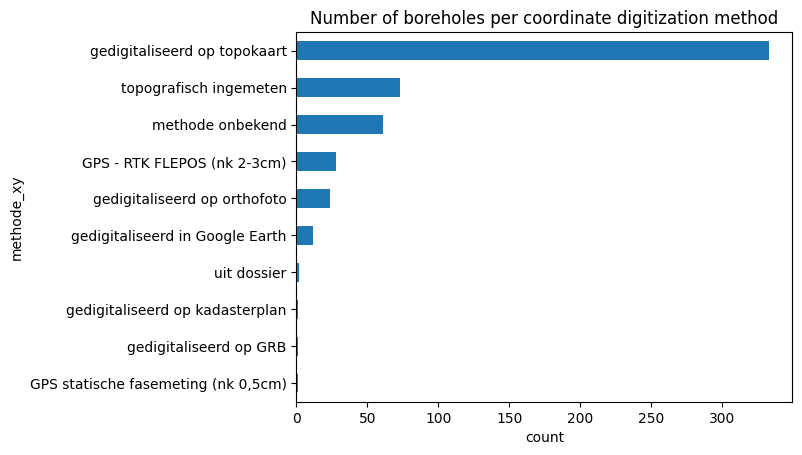

In [29]:
df_plot = df.groupby('methode_xy').size().sort_values()

ax = df_plot.plot.barh()

ax.set_xlabel("count")
ax.set_title("Number of boreholes per coordinate digitization method")

Text(0.5, 1.0, 'Number of boreholes per height digitization method')

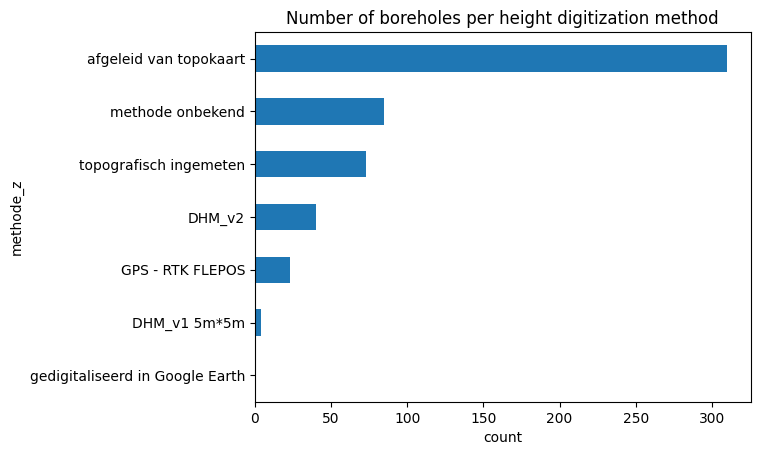

In [30]:
df_plot = df.groupby('methode_z').size().sort_values()

ax = df_plot.plot.barh()

ax.set_xlabel("count")
ax.set_title("Number of boreholes per height digitization method")

## Adding color to the Borehole dataframe

The default dataframe of the Boring datatype contains information about the 'boormethode' as its subtype. However, in the DOV database there is information about the observed color of the soil in the various depth intervals available as well. We can access this data in pydov by using the subtype `Kleur`.

To check the available subtypes for a the `Boring` type, you can use:

In [31]:
from pydov.types.boring import Boring

Boring.get_subtypes()

{'BoorMethode': {'name': 'BoorMethode',
  'class': pydov.types.boring.BoorMethode,
  'definition': 'Subtype listing the method used to make the borehole. It has the following fields: diepte_methode_van, diepte_methode_tot, boormethode.'},
 'Kleur': {'name': 'Kleur',
  'class': pydov.types.boring.Kleur,
  'definition': 'Subtype listing the color values of the borehole. It has the following fields: diepte_kleur_van, diepte_kleur_tot, kleur.'}}

To retrieve the colors instead of the method, we can instantiate the search class with the `Kleur` subtype:

In [32]:
from pydov.search.boring import BoringSearch
from pydov.types.boring import Kleur

boring_search = BoringSearch(
    objecttype=Boring.with_subtype(Kleur)
)

The extra fields are now available, and should be included in the output of `get_fields()`. E.g. to get more details about the `kleur` field:

In [33]:
boring_search.get_fields()['kleur']

{'name': 'kleur', 'type': 'string', 'list': False, 'definition': 'Grondkleur voor het diepte-interval', 'notnull': False, 'query': False, 'cost': 10}

And the color data is returned when querying:

In [34]:
boring_search.search(
    location=WithinDistance(Point(157647.0, 186350.0), 10))

[000/001] .
[000/001] .


,pkey_boring,boornummer,x,y,mv_mtaw,start_boring_mtaw,gemeente,diepte_boring_van,diepte_boring_tot,datum_aanvang,uitvoerder,boorgatmeting,diepte_kleur_van,diepte_kleur_tot,kleur
0,https://www.dov.vlaanderen.be/data/boring/1966...,GEO-66/037-IIA-b202,157647.0,186350.0,NaN,7.45,NaN,0.0,6.0,1966-06-28,Rijksinstituut voor Grondmechanica,False,0.00,1.25,bruin
1,https://www.dov.vlaanderen.be/data/boring/1966...,GEO-66/037-IIA-b202,157647.0,186350.0,NaN,7.45,NaN,0.0,6.0,1966-06-28,Rijksinstituut voor Grondmechanica,False,1.25,2.30,bruinroest
2,https://www.dov.vlaanderen.be/data/boring/1966...,GEO-66/037-IIA-b202,157647.0,186350.0,NaN,7.45,NaN,0.0,6.0,1966-06-28,Rijksinstituut voor Grondmechanica,False,2.30,2.75,bruin
3,https://www.dov.vlaanderen.be/data/boring/1966...,GEO-66/037-IIA-b202,157647.0,186350.0,NaN,7.45,NaN,0.0,6.0,1966-06-28,Rijksinstituut voor Grondmechanica,False,2.75,2.90,bruin
4,https://www.dov.vlaanderen.be/data/boring/1966...,GEO-66/037-IIA-b202,157647.0,186350.0,NaN,7.45,NaN,0.0,6.0,1966-06-28,Rijksinstituut voor Grondmechanica,False,2.90,3.40,groenzwart
5,https://www.dov.vlaanderen.be/data/boring/1966...,GEO-66/037-IIA-b202,157647.0,186350.0,NaN,7.45,NaN,0.0,6.0,1966-06-28,Rijksinstituut voor Grondmechanica,False,3.40,4.30,donkerbruin
6,https://www.dov.vlaanderen.be/data/boring/1966...,GEO-66/037-IIA-b202,157647.0,186350.0,NaN,7.45,NaN,0.0,6.0,1966-06-28,Rijksinstituut voor Grondmechanica,False,4.30,4.75,grijs
7,https://www.dov.vlaanderen.be/data/boring/1966...,GEO-66/037-IIA-b202,157647.0,186350.0,NaN,7.45,NaN,0.0,6.0,1966-06-28,Rijksinstituut voor Grondmechanica,False,4.75,6.00,grijs
